In [1]:
import pandas as pd
import numpy as np
import os
from sklearn import preprocessing,metrics 
from sklearn import cluster
import numpy.random as npr
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.metrics import classification_report, mean_squared_error, r2_score, average_precision_score, precision_recall_curve, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)

In [2]:
data = pd.read_csv("LendingClub2012to2013.csv",low_memory = False, skiprows = 1)
print (data.shape)
#print (data.columns)

(188183, 115)


In [3]:
data.loan_status.value_counts()

Fully Paid            143919
Charged Off            27536
Current                15430
Late (31-120 days)       706
In Grace Period          387
Late (16-30 days)        175
Default                   28
Name: loan_status, dtype: int64

In [4]:
status, count = data["loan_status"].value_counts().index, data["loan_status"].value_counts().values
loan_status_index = pd.DataFrame({'Loan Status': status,'Count': count})[['Loan Status','Count']]
print(loan_status_index)

          Loan Status   Count
0          Fully Paid  143919
1         Charged Off   27536
2             Current   15430
3  Late (31-120 days)     706
4     In Grace Period     387
5   Late (16-30 days)     175
6             Default      28


In [5]:
newdata = data[(data['loan_status']=="Fully Paid") | (data['loan_status']=="Charged Off")]
boolean = {"Fully Paid":1, "Charged Off":0} 
data = newdata.replace({"loan_status": boolean})

In [6]:
data['loan_status'].value_counts()

1    143919
0     27536
Name: loan_status, dtype: int64

In [7]:
#dropping the variables which are not related to loan status and finances and 90% of these columns are empty

data = data.drop(['id', 'member_id','all_util', 'annual_inc_joint', 'application_type', 'avg_cur_bal', 
             'bc_open_to_buy', 'bc_util', 'desc', 'dti_joint', 'earliest_cr_line',
             'emp_title','funded_amnt_inv', 'il_util', 'inq_fi','inq_last_12m', 'issue_d',
             'last_credit_pull_d', 'last_pymnt_d', 'max_bal_bc',
             'mths_since_last_major_derog', 'mths_since_last_record', 'mo_sin_old_il_acct', 
             'mo_sin_old_rev_tl_op', 'mths_since_rcnt_il', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 
             'mths_since_last_delinq','mths_since_recent_bc', 'mths_since_recent_bc_dlq', 
             'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'num_accts_ever_120_pd', 
             'num_actv_bc_tl', 'num_actv_rev_tl', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 
             'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl','num_rev_accts', 'num_rev_tl_bal_gt_0', 
             'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m', 'open_acc_6m', 
             'open_il_12m', 'open_il_24m','open_il_6m', 'open_rv_12m', 'open_rv_24m', 'out_prncp_inv', 
             'pct_tl_nvr_dlq','percent_bc_gt_75', 'pymnt_plan', 'policy_code', 'title', 'total_bal_il', 
             'tot_coll_amt', 'total_cu_tl',  'tot_cur_bal', 'tot_hi_cred_lim', 'total_il_high_credit_limit',
             'total_pymnt_inv', 'total_rev_hi_lim', 'url','verification_status_joint'], axis=1)

print (data.shape)

(171455, 46)


In [8]:
#Replacing missing values with Nan
data = data.apply(lambda x: x.str.strip() if isinstance(x, str) else x).replace('', np.nan)

In [9]:
print (data.shape)

(171455, 46)


In [10]:
nullcount = data.isnull().sum()
print("Null values:\n{}".format(nullcount))

Null values:
loan_amnt                        0
funded_amnt                      0
term                             0
int_rate                         0
installment                      0
grade                            0
sub_grade                        0
emp_length                       0
home_ownership                   0
annual_inc                       0
verification_status              0
loan_status                      0
purpose                          0
zip_code                         0
addr_state                       0
dti                              0
delinq_2yrs                      0
fico_range_low                   0
fico_range_high                  0
inq_last_6mths                   0
open_acc                         0
pub_rec                          0
revol_bal                        0
revol_util                     117
total_acc                        0
initial_list_status              0
out_prncp                        0
total_pymnt                      0
total_r

In [11]:
data.dropna(how='any', inplace = True)
data.shape

(164139, 46)

# Data Correlation

In [12]:
cor = data.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.55) | (cor < -0.55)]

funded_amnt              loan_amnt               0.999904
installment              loan_amnt               0.963494
                         funded_amnt             0.963596
fico_range_high          fico_range_low          1.000000
total_acc                open_acc                0.665553
total_pymnt              loan_amnt               0.889418
                         funded_amnt             0.889540
                         installment             0.869361
total_rec_prncp          loan_amnt               0.826782
                         funded_amnt             0.826910
                         installment             0.823107
                         total_pymnt             0.968188
total_rec_int            loan_amnt               0.719249
                         funded_amnt             0.719315
                         installment             0.665525
                         total_pymnt             0.772346
                         total_rec_prncp         0.600124
collection_rec

In [68]:
#Based on correlation calculation dropping the following values
data.drop(['funded_amnt','fico_range_high', 'total_acc', 'total_rec_int', 'collection_recovery_fee', 'last_pymnt_amnt',
           'last_fico_range_low', 'pub_rec_bankruptcies', 'tax_liens'],axis=1, inplace=True)

print("Shape :",data.shape)

Shape : (164139, 37)


Data Encoding for certain variables

In [13]:
data['grade'] = data['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})

data["home_ownership"] = data["home_ownership"].map({"MORTGAGE":1,"RENT":2,"OWN":3,"OTHER":4,"NONE":5,"ANY":6})

data["verification_status"] = data["verification_status"].map({"Verified":1,"Not Verfified":2, "Source Verfied":3})

#code used from stackoverflow.com
data["emp_length"] = data["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0'}, regex = True)
#code used from stackoverflow.com

data["emp_length"] = data["emp_length"].apply(lambda x:int(x))


data.head(2)

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,collections_12_mths_ex_med,acc_now_delinq,acc_open_past_24mths,chargeoff_within_12_mths,delinq_amnt,mort_acc,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit
0,20800.0,20800.0,36 months,13.53%,706.16,6,B5,10,2,81500.0,...,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,23473.0,15000.0
2,12000.0,12000.0,36 months,10.99%,392.81,6,B2,4,2,60000.0,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,7137.0,18100.0


In [14]:
#code from textbook- Handbook for scikit learn
data ['int_rate'] = data['int_rate'].apply(lambda x:float(x.rstrip('%'))/100)
#removing % sign, conv to float  - int_rate column
data= data.reset_index(drop=True)

Relationship between term and Grade of the loan

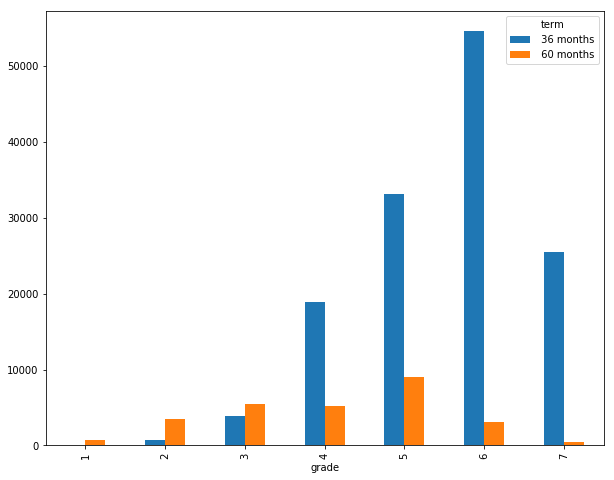

In [15]:
data.groupby(['grade','term']).size().unstack().plot(kind='bar')

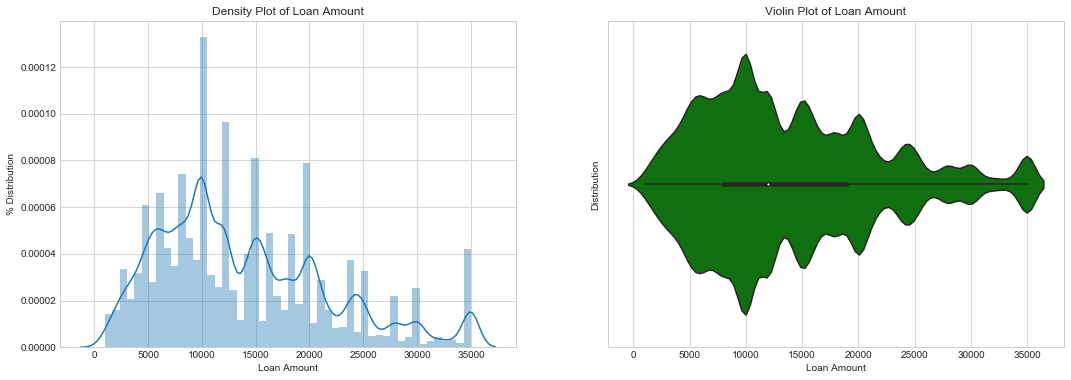

In [16]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(1,2,figsize=(18,6))
sns.distplot(data.loan_amnt, ax=axs[0])
axs[0].set(xlabel='Loan Amount', 
       ylabel='% Distribution',title='Density Plot of Loan Amount')
sns.violinplot(data.loan_amnt,color="g", ax=axs[1])
axs[1].set(xlabel='Loan Amount', 
       ylabel='Distribution',title='Violin Plot of Loan Amount')
plt.legend()
plt.show()

Relationship between loan_status and purpose of the loan

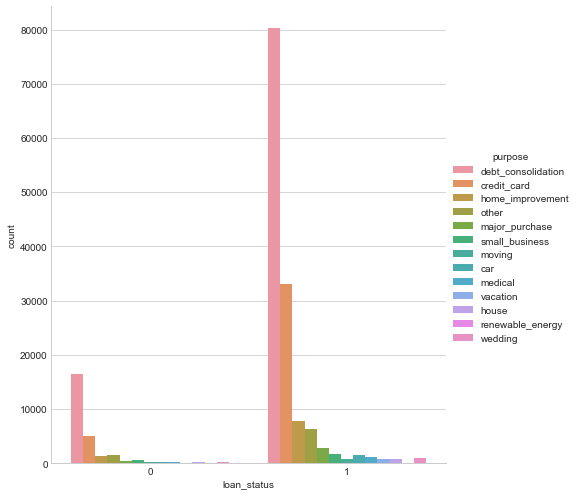

In [17]:
a = sns.factorplot(x = "loan_status", hue = "purpose", data = data, 
                   kind = 'count', size = 7, aspect = .9)

In [18]:
#Encode the categorical data
from sklearn.preprocessing import LabelEncoder

a = LabelEncoder()

data = data
     
cols_encode = ['sub_grade', 'emp_length', 'purpose','initial_list_status','addr_state', 'zip_code', 'term']

for col_name in cols_encode:
    data[col_name] = a.fit_transform(data[col_name].astype('str'))

In [19]:
cleandata = data [['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
           'emp_length', 'home_ownership', 'annual_inc','purpose', 'zip_code', 
           'addr_state', 'dti','delinq_2yrs', 'fico_range_low', 'inq_last_6mths', 'open_acc',
           'revol_bal', 'initial_list_status',
           'total_pymnt', 'total_rec_prncp',
           'last_fico_range_high','total_bal_ex_mort', 'total_bc_limit','loan_status']]
cleandata.shape

(164139, 25)

In [20]:
scl = preprocessing.StandardScaler() #instance of preprocessing
fields = cleandata.columns.values[:-1]
data = pd.DataFrame(scl.fit_transform(cleandata[fields]), columns = fields)
cleandata['loan_status'] = cleandata['loan_status']
cleandata['loan_status'].value_counts()

1    137828
0     26311
Name: loan_status, dtype: int64

In [21]:
X = cleandata [['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
           'emp_length', 'home_ownership', 'annual_inc','purpose', 'zip_code', 
           'addr_state', 'dti','delinq_2yrs', 'fico_range_low', 'inq_last_6mths', 'open_acc',
           'revol_bal', 'initial_list_status',
           'total_pymnt', 'total_rec_prncp',
           'last_fico_range_high','total_bal_ex_mort', 'total_bc_limit']]

Y = cleandata[['loan_status']]

In [22]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size = 0.2)

In [23]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_train1, Y_train1, test_size=0.1)

In [24]:
nullcount = X.isnull().sum()
print("Number of null values:\n{}".format(nullcount))

Number of null values:
loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
emp_length              0
home_ownership          0
annual_inc              0
purpose                 0
zip_code                0
addr_state              0
dti                     0
delinq_2yrs             0
fico_range_low          0
inq_last_6mths          0
open_acc                0
revol_bal               0
initial_list_status     0
total_pymnt             0
total_rec_prncp         0
last_fico_range_high    0
total_bal_ex_mort       0
total_bc_limit          0
dtype: int64


In [25]:
from sklearn.feature_selection import RFE

clf_LR = linear_model.LogisticRegression()
clf_LR.fit(X_train2,Y_train2)
rfe = RFE(clf_LR, 10)
rfe = rfe.fit(X_train2, Y_train2)
# summarize the selection of the attributes
print('No.of features: ' +  str ((rfe.n_features_)))
print(rfe.support_)
print(rfe.ranking_)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


No.of features: 10
[ True False False  True False False False False False False  True  True
  True False  True False  True False False  True  True  True False False]
[ 1 10 13  1  3  2  8 11  6  4  1  1  1 14  1 12  1  7 15  1  1  1  9  5]


In [26]:
X.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,purpose,zip_code,addr_state,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,revol_bal,initial_list_status,total_pymnt,total_rec_prncp,last_fico_range_high,total_bal_ex_mort,total_bc_limit
loan_amnt,1.0,0.4,0.13,0.96,-0.14,0.16,0.0088,-0.17,0.37,-0.14,-0.0049,0.013,0.03,0.0087,0.11,0.026,0.19,0.32,0.022,0.89,0.83,0.066,0.28,0.37
term,0.4,1.0,0.44,0.18,-0.45,0.47,0.012,-0.094,0.076,-0.013,-0.022,0.017,0.059,0.0029,-0.0067,0.063,0.071,0.081,-0.015,0.31,0.19,-0.096,0.1,0.067
int_rate,0.13,0.44,1.0,0.13,-0.96,0.99,0.0087,0.1,-0.045,0.18,-0.0049,0.0038,0.14,0.09,-0.56,0.25,0.0029,-0.022,-0.037,0.11,-0.028,-0.34,0.026,-0.28
installment,0.96,0.18,0.13,1.0,-0.13,0.14,0.0084,-0.14,0.36,-0.13,4.3e-05,0.0093,0.032,0.02,0.051,0.04,0.19,0.31,0.022,0.87,0.82,0.06,0.27,0.34
grade,-0.14,-0.45,-0.96,-0.13,1.0,-0.98,-0.0073,-0.092,0.03,-0.19,0.0076,-0.0041,-0.12,-0.085,0.5,-0.25,-0.0078,0.018,0.038,-0.12,0.022,0.32,-0.032,0.25
sub_grade,0.16,0.47,0.99,0.14,-0.98,1.0,0.0077,0.095,-0.03,0.19,-0.0065,0.0044,0.13,0.087,-0.52,0.26,0.0083,-0.015,-0.036,0.12,-0.016,-0.33,0.036,-0.26
emp_length,0.0088,0.012,0.0087,0.0084,-0.0073,0.0077,1.0,-0.02,0.0048,-0.0027,0.011,-0.02,-0.0017,-0.021,-0.013,0.0018,0.0075,-0.026,-0.0038,0.0056,0.0044,-0.017,-0.005,-0.026
home_ownership,-0.17,-0.094,0.1,-0.14,-0.092,0.095,-0.02,1.0,-0.17,0.039,-0.011,-0.043,0.019,-0.044,-0.099,-0.08,-0.12,-0.12,-0.017,-0.15,-0.16,-0.071,-0.13,-0.12
annual_inc,0.37,0.076,-0.045,0.36,0.03,-0.03,0.0048,-0.17,1.0,0.015,-0.016,-0.0023,-0.2,0.068,0.11,0.085,0.16,0.34,0.021,0.35,0.35,0.083,0.39,0.29
purpose,-0.14,-0.013,0.18,-0.13,-0.19,0.19,-0.0027,0.039,0.015,1.0,-0.015,-0.0051,-0.078,0.017,0.064,0.053,-0.072,-0.063,-0.033,-0.13,-0.14,-0.06,-0.02,-0.068


# Variable Visualization

Visualization of relation between the Grade and Interest - Rate

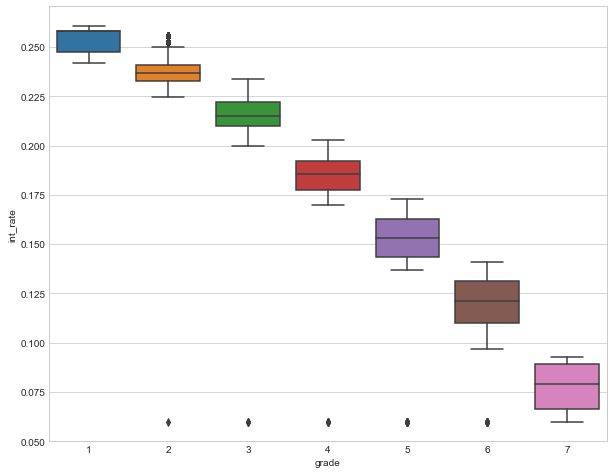

In [27]:
sns.boxplot(x='grade', y='int_rate', data=X)

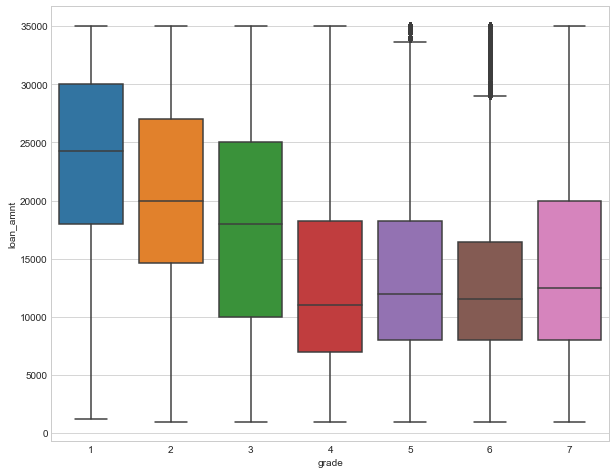

In [28]:
sns.boxplot(x='grade', y='loan_amnt', data=X)

Visualization of Annual Income

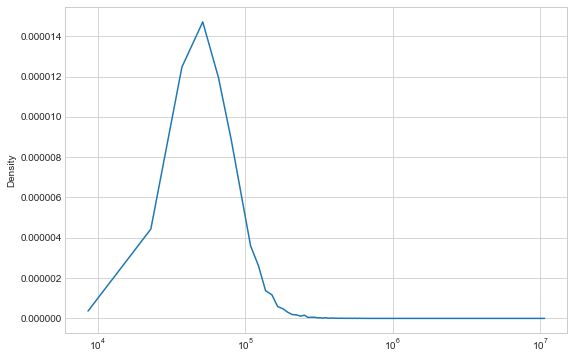

In [29]:
plt.rcParams['figure.figsize'] = (9,6)
X["annual_inc"].plot.density(logx = True)

Density Plot of Interest Rate

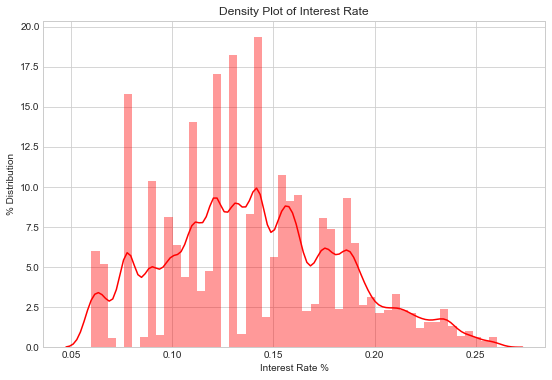

In [30]:
plt.rcParams['figure.figsize'] = (9,6)
ax=sns.distplot(X.int_rate, color="r")
ax.set(xlabel='Interest Rate %', 
       ylabel='% Distribution',title='Density Plot of Interest Rate')

plt.legend();

Density plot of Grade

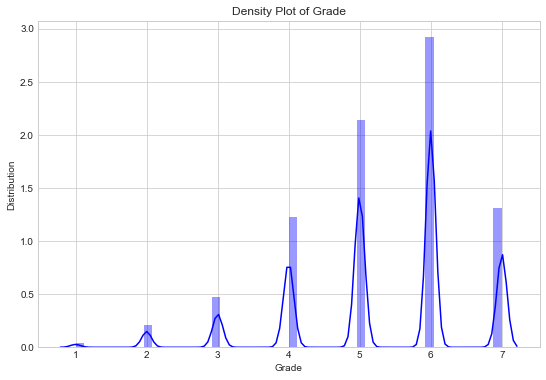

In [31]:
plt.rcParams['figure.figsize'] = (9,6)
ax=sns.distplot(X.grade, color="b")
ax.set(xlabel='Grade', 
       ylabel='Distribution',title='Density Plot of Grade')

plt.legend()

Visualisation of frequency of each loan status and percentage of each loan-status

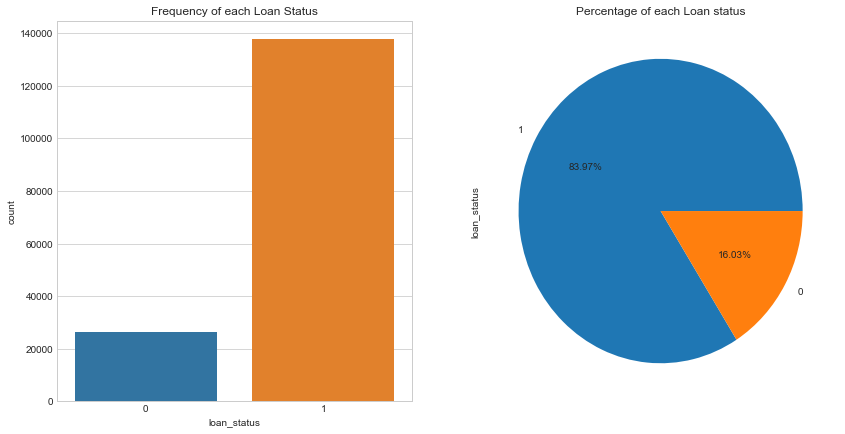

In [32]:
fig, axs = plt.subplots(1,2,figsize=(14,7))
sns.countplot(x='loan_status',data=Y,ax=axs[0])
axs[0].set_title("Frequency of each Loan Status")
Y.loan_status.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of each Loan status")
plt.show()

In [34]:
median_dti = cleandata.dti.median()
ninety_ninth_percentile = cleandata.dti.quantile(.9999)
cleandata.loc[cleandata.dti > ninety_ninth_percentile, 'dti'] = median_dti

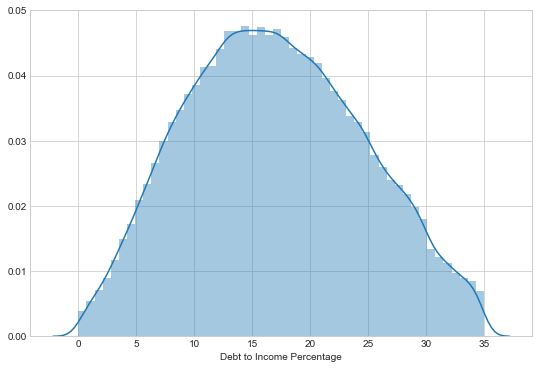

In [35]:
sns.distplot(cleandata.dti, axlabel='Debt to Income Percentage');

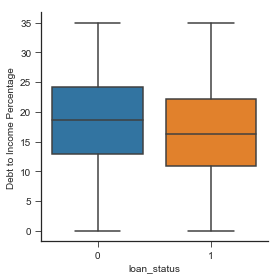

In [36]:
with sns.axes_style(style='ticks'):
    g = sns.factorplot("loan_status", "dti", data=cleandata, kind="box")
    g.set_axis_labels("loan_status", "Debt to Income Percentage");

# Models Used:

# Logistics Regression

In [77]:
logreg = linear_model.LogisticRegression()

print('Cross Validation Score :')

cross_val_score(logreg,X_train1,np.ravel(Y_train1,order ='C'), cv = 10)


Cross Validation Score :


array([ 0.99779165,  0.99794395,  0.99809625,  0.9980201 ,  0.99817226,
        0.99855304,  0.99824842,  0.99824829,  0.99840061,  0.99817212])

In [78]:
logreg.fit(X_train2, np.ravel(Y_train2,order = 'C'))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [79]:
logpredict = logreg.predict(X_test2)
print(logpredict)

[1 1 1 ..., 0 1 0]


In [80]:
print('Accuracy Score: ' +  str(accuracy_score(Y_test2, logpredict.round())))

print('Classification Report :')

print(classification_report(Y_test2, logpredict.round()))

Accuracy Score: 0.998400852878
Classification Report :
             precision    recall  f1-score   support

          0       1.00      0.99      0.99      2088
          1       1.00      1.00      1.00     11044

avg / total       1.00      1.00      1.00     13132



In [81]:
print('RMSE for logistic regression : ' + 
      str(np.sqrt(mean_squared_error(logpredict, Y_test2))) 
      + ', R^2: ' + str(r2_score(logpredict, Y_test2)))

RMSE for logistic regression : 0.0399893375981, R^2: 0.987970848111


In [82]:
#Classifier On 20% of hold out data
logpredict = logreg.predict(X_test1)

In [83]:
#Classification report on 20% of the hold out data
print('Classification Report :')

print(classification_report(Y_test1, logpredict))

Classification Report :
             precision    recall  f1-score   support

          0       1.00      0.99      0.99      5277
          1       1.00      1.00      1.00     27551

avg / total       1.00      1.00      1.00     32828



# KNN

In [84]:
knn = KNeighborsRegressor()

print('Cross Validation Score :')
cross_val_score(knn,X_train1,Y_train1, cv = 10)

Cross Validation Score :


array([ 0.64297961,  0.64058188,  0.6476919 ,  0.63703619,  0.64325544,
        0.64236414,  0.64707363,  0.65387258,  0.63594446,  0.65312206])

In [85]:
knn.fit(X_train2, Y_train2)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [86]:
knn_pred = knn.predict(X_test2)
print (knn_pred)

[[ 1.]
 [ 1.]
 [ 1.]
 ..., 
 [ 0.]
 [ 1.]
 [ 1.]]


In [87]:
print('RMSE for KNN regression: ' + str(np.sqrt(mean_squared_error(knn_pred, Y_test2))))
      
print('R^2:' + str(r2_score(knn_pred, Y_test2)))

RMSE for KNN regression: 0.223695323887
R^2:0.39868780832


In [88]:
print('Accuracy Score: ' +  str(accuracy_score(Y_test2,knn_pred.round())))

Accuracy Score: 0.9402223576


In [89]:
print('Classification Report : ')

print(classification_report(Y_test2, knn_pred.round()))

Classification Report : 
             precision    recall  f1-score   support

          0       0.98      0.64      0.77      2088
          1       0.94      1.00      0.97     11044

avg / total       0.94      0.94      0.93     13132



In [90]:
#Classifier On 20% of hold out data
knn_pred = knn.predict(X_test1)
print (knn_pred)

[[ 1. ]
 [ 1. ]
 [ 1. ]
 ..., 
 [ 1. ]
 [ 1. ]
 [ 0.2]]


In [91]:
#Classification report on 20% of the hold out data
print('Classification Report : ')

print(classification_report(Y_test1, knn_pred.round()))

Classification Report : 
             precision    recall  f1-score   support

          0       0.98      0.65      0.78      5277
          1       0.94      1.00      0.97     27551

avg / total       0.94      0.94      0.94     32828



# Decision Tree

In [92]:
clf = tree.DecisionTreeClassifier() 

print('Cross Validation Score :')

cross_val_score(clf, X_train1,Y_train1, cv=10)

Cross Validation Score :


array([ 0.99588791,  0.99565946,  0.99703016,  0.9972586 ,  0.99642068,
        0.996573  ,  0.99702993,  0.99672506,  0.99512567,  0.9966489 ])

In [93]:
clf = clf.fit(X_train2, Y_train2)

Dt_predict = clf.predict(X_test2)

In [94]:
print('Accuracy Score: ' +  str (accuracy_score(Y_test2,Dt_predict)))

print('Classification Report : ')
      
print(classification_report(Y_test2, Dt_predict))

Accuracy Score: 0.996116356991
Classification Report : 
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      2088
          1       1.00      1.00      1.00     11044

avg / total       1.00      1.00      1.00     13132



In [95]:
print('RMSE: ' + 
      str(np.sqrt(mean_squared_error(Dt_predict, Y_test2))) 
      + ', R^2: ' + str(r2_score(Dt_predict, Y_test2)))

RMSE: 0.0623188816447, R^2: 0.970990609281


In [96]:
#Classifier On 20% of hold out data
Dt_predict = clf.predict(X_test1)

In [97]:
#Classification report on 20% of the hold out data
print('Classification Report : ')
      
print(classification_report(Y_test1, Dt_predict))

Classification Report : 
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      5277
          1       1.00      1.00      1.00     27551

avg / total       1.00      1.00      1.00     32828



# Gaussian NB

In [98]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()

In [99]:
print('Cross Validation Score :')

(cross_val_score(GNB, X_train1,np.ravel(Y_train1,order = 'C') , cv = 10))

Cross Validation Score :


array([ 0.8898873 ,  0.8911057 ,  0.89453244,  0.89430399,  0.8809687 ,
        0.89155434,  0.8950575 ,  0.88956588,  0.89847677,  0.89573496])

In [100]:
GNB = GNB.fit(X_train2,np.ravel(Y_train2,order = 'C'))

GNB_pred = GNB.predict(X_test2)

In [101]:
print('Accuracy Score: ' +  str(accuracy_score(Y_test2, GNB_pred.round())))

Accuracy Score: 0.892171794091


In [102]:
print('RMSE for GNB : ' + 
      str(np.sqrt(mean_squared_error(GNB_pred, Y_test2))) 
      + ', R^2: ' + str(r2_score(GNB_pred, Y_test2)))

RMSE for GNB : 0.328372054093, R^2: 0.339819359237


In [103]:
print('Classification Report : ')
      
print(classification_report(Y_test2,GNB_pred))

Classification Report : 
             precision    recall  f1-score   support

          0       0.62      0.81      0.70      2088
          1       0.96      0.91      0.93     11044

avg / total       0.91      0.89      0.90     13132



In [104]:
#Classifier On 20% of hold out data
GNB_pred = GNB.predict(X_test1)

In [105]:
#Classification report on 20% of the hold out data
print('Classification Report : ')
      
print(classification_report(Y_test1,GNB_pred))

Classification Report : 
             precision    recall  f1-score   support

          0       0.62      0.81      0.70      5277
          1       0.96      0.90      0.93     27551

avg / total       0.91      0.89      0.89     32828

